In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
register_matplotlib_converters()

##Загрузка датасета

In [ ]:
df = pd.read_json("sber.json")
df.head()

,date,close,open,low,high,trendclspr,volume,value,numtrades
0,2022-03-28,125.00,130.60,125.00,131.47,-4.94,33212430,4.203875e+09,121793
1,2022-03-29,128.77,126.16,122.00,137.57,3.02,72338740,9.470337e+09,184608
2,2022-03-30,134.60,136.89,131.11,138.40,4.53,35675450,4.754054e+09,102479
3,2022-03-31,143.69,135.25,134.52,147.41,6.75,118425000,1.666945e+10,255603
4,2022-04-01,154.50,145.00,144.51,155.40,7.52,118880720,1.802233e+10,265276


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1066 non-null   datetime64[ns]
 1   close       1066 non-null   float64       
 2   open        1066 non-null   float64       
 3   low         1066 non-null   float64       
 4   high        1066 non-null   float64       
 5   trendclspr  1066 non-null   float64       
 6   volume      1066 non-null   int64         
 7   value       1066 non-null   float64       
 8   numtrades   1066 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 75.1 KB


##Предобработка

In [ ]:
df = df.sort_values('date').reset_index(drop=True)
df = df.dropna()
df.set_index('date', inplace=True)

df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day
df['is_month_start'] = df.index.is_month_start.astype(int)

In [ ]:
target_col = 'close'
features = ['close', 'open', 'low', 'high', 'trendclspr', 'volume', 'value', 'numtrades',
            'dayofweek', 'month', 'day', 'is_month_start']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

####Создание последовательностей окон для модели

In [ ]:
def create_gru_dataset(data, input_steps=20, output_steps=48, target_col=0):
    X, y = [], []
    for i in range(input_steps, len(data) - output_steps + 1):
        X.append(data[i - input_steps:i])
        y.append(data[i:i + output_steps, target_col])  # close
    return np.array(X), np.array(y)

X_48, y_48 = create_gru_dataset(scaled_data, input_steps=30, output_steps=48)
X_240, y_240 = create_gru_dataset(scaled_data, input_steps=30, output_steps=240)

##Создание модели и обучение

In [ ]:
def build_gru_model(input_shape, output_steps):
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(output_steps))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_48 = build_gru_model(X_48.shape[1:], 48)
model_240 = build_gru_model(X_240.shape[1:], 240)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_48.fit(X_48, y_48, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.2592 - mae: 0.4084 - val_loss: 0.0159 - val_mae: 0.1006
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0452 - mae: 0.1587 - val_loss: 0.0089 - val_mae: 0.0745
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0255 - mae: 0.1191 - val_loss: 0.0092 - val_mae: 0.0742
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0221 - mae: 0.1111 - val_loss: 0.0091 - val_mae: 0.0740
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - mae: 0.1012 - val_loss: 0.0091 - val_mae: 0.0770
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - mae: 0.0981 - val_loss: 0.0088 - val_mae: 0.0754
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0156 - mae: 0.0939 - val_loss: 0.0088 - val_mae: 0.0750
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138 - mae: 0.0881 - val_loss: 0.0087 - val_mae: 0.0728
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.012

In [ ]:
print("X shape:", X_48.shape)
print("sample X:", X_48[sample_index:].shape)
print("y shape:", y_48.shape)
print("sample y:", y_48[sample_index].shape)

X shape: (989, 30, 12)


NameError: name 'sample_index' is not defined

##Предсказания

In [ ]:
y_pred = model_48.predict(X_48[-1:])[0]
y_true = y_48[-1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


In [ ]:
def plot_forecast_with_metrics_denorm(y_true, y_pred, scaler, target_col_index,
                                      title="Прогноз vs Факт", steps_ahead=48):
    y_true_full = np.zeros((steps_ahead, scaler.n_features_in_))
    y_pred_full = np.zeros((steps_ahead, scaler.n_features_in_))
    y_true_full[:, target_col_index] = y_true
    y_pred_full[:, target_col_index] = y_pred
    y_true_denorm = scaler.inverse_transform(y_true_full)[:, target_col_index]
    y_pred_denorm = scaler.inverse_transform(y_pred_full)[:, target_col_index]

    mse = mean_squared_error(y_true_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_true_denorm, y_pred_denorm)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_denorm, y_pred_denorm)
    mape = mean_absolute_percentage_error(y_true_denorm, y_pred_denorm)
    print(f"\nМетрики:")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"MAPE: {mape:.3f}")

    plt.figure(figsize=(14, 5))
    plt.plot(y_true_denorm, label='Факт', marker='o', color='blue')
    plt.plot(y_pred_denorm, label='Прогноз (GRU)', marker='o', color='orange')
    plt.title(f"{title}")

    plt.ylabel("Цена закрытия")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



Метрики:
MSE: 407.939
MAE: 17.546
RMSE: 20.197
R²: -0.460
MAPE: 0.056


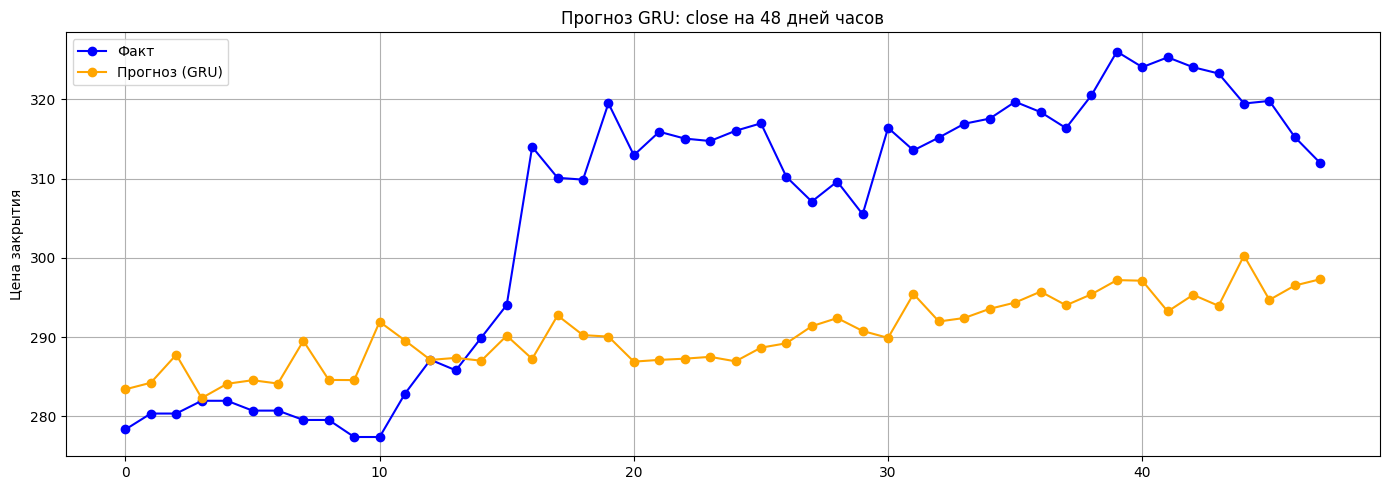

In [ ]:

plot_forecast_with_metrics_denorm(
    y_true, y_pred,
    scaler=scaler,
    target_col_index=features.index('close'),
    title="Прогноз GRU: close на 48 дней часов",
    steps_ahead=48
)